<a href="https://colab.research.google.com/github/SarahEverke/SarahEverke-IIC3633-2020/blob/master/practicos/Implicit_implicit_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [ ]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    424      0 --:--:-- --:--:-- --:--:--   423
100 1546k  100 1546k    0     0  1181k      0  0:00:01  0:00:01 --:--:-- 8593k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    710      0 --:--:-- --:--:-- --:--:--   711
100  385k  100  385k    0     0   431k      0 --:--:-- --:--:-- --:--:-- 2858k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    714      0 --:--:-- --:--:-- --:--:--   715
100  230k  100  230k    0     0   221k      0  0:00:01  0:00:01 --:--:--  804k


In [ ]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1MB 8.4MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3420089 sha256=c2ce5c2ae092c7eeeaf07948657cc529680e49e33e53f080d0cf7c520aa3b49e
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [ ]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [ ]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [ ]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [ ]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [ ]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [ ]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])


In [ ]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [ ]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse
filas:usuarios
columnas:items
0 o 1 si interactúa positivamente o no

In [ ]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()


In [ ]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [ ]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [ ]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

---



**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:**
El algoritmo ALS utiliza dos variables una de confianza y otra de preferencia. Para encontrar la recomendación se minimiza una función que relaciona esas variables. 

In [ ]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [ ]:
show_recommendations(model_als, user=77, n=1)

movieid
256    When the Cats Away (Chacun cherche son chat) (...
Name: title, dtype: object

In [ ]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.06943849374204711
ndcg: 0.34762633996937214


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [ ]:
factors = [10, 25, 50, 75, 100, 125] 
map_values = []
ndcg_values = []

for k in factors:  
  model_als_test = implicit.als.AlternatingLeastSquares(factors=k, iterations=10, use_gpu=False)
  model_als_test.fit(matrix)
  maprec, ndcg = evaluate_model(model_als_test, n=10)
  map_values.append(maprec)
  ndcg_values.append(ndcg)



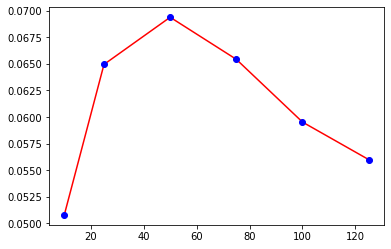

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(factors, map_values, 'r-')
plt.plot(factors, map_values, 'bo')
plt.show()

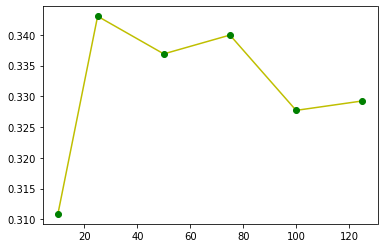

In [ ]:
plt.plot(factors, ndcg_values, 'y-')
plt.plot(factors, ndcg_values, 'go')
plt.show()

Escogí 50 factores y ahora probaré con el número de iteraciones

In [ ]:
iterations = [1, 10, 25, 50, 75] 
map_values = []
ndcg_values = []

for k in iterations:  
  model_als_test = implicit.als.AlternatingLeastSquares(factors=50, iterations=k, use_gpu=False)
  model_als_test.fit(matrix)
  maprec, ndcg = evaluate_model(model_als_test, n=10)
  map_values.append(maprec)
  ndcg_values.append(ndcg)

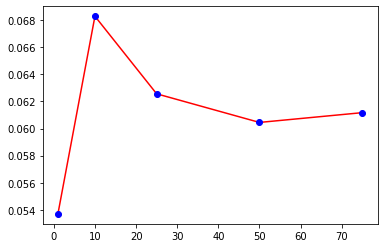

In [ ]:
plt.plot(iterations, map_values, 'r-')
plt.plot(iterations, map_values, 'bo')
plt.show()

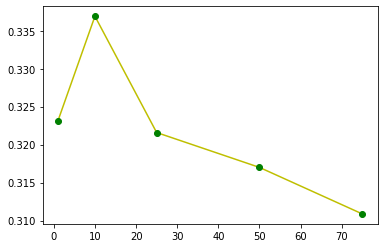

In [ ]:
plt.plot(iterations, ndcg_values, 'y-')
plt.plot(iterations, ndcg_values, 'go')
plt.show()

Encuentro interesante que tanto el ndcg como map disminuyan con más iteraciones.



## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.
En este algoritmo que utiliza tuplas (usuario, item +, item -), mediante al teorema de Bayes y el estimador de máxima verosimilitud obtienen una expresión que será optmizada. 

In [ ]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [ ]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257                               Men in Black (1997)
299                                    Hoodlum (1997)
285                             Secrets & Lies (1996)
332                             Kiss the Girls (1997)
267                                           unknown
746                                Real Genius (1985)
327                                   Cop Land (1997)
244                     Smilla's Sense of Snow (1997)
676                              Crucible, The (1996)
312    Midnight in the Garden of Good and Evil (1997)
Name: title, dtype: object

In [ ]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                Delicatessen (1991)
209          This Is Spinal Tap (1984)
21       Muppet Treasure Island (1996)
27                     Bad Boys (1995)
203                  Unforgiven (1992)
68                    Crow, The (1994)
201                Evil Dead II (1987)
78                   Free Willy (1993)
172    Empire Strikes Back, The (1980)
173         Princess Bride, The (1987)
Name: title, dtype: object

In [ ]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.0529045033469722
ndcg: 0.3445635528330781


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

In [ ]:
factors = [50, 100, 200, 300, 400, 500, 600] 
map_values = []
ndcg_values = []

for k in factors:  
  model_bpr_test = implicit.bpr.BayesianPersonalizedRanking(factors=k, iterations=40, use_gpu=False)
  model_bpr_test.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr_test, n=10)
  map_values.append(maprec)
  ndcg_values.append(ndcg)

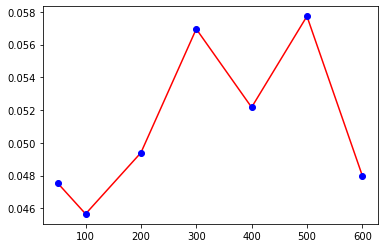

In [ ]:
plt.plot(factors, map_values, 'r-')
plt.plot(factors, map_values, 'bo')
plt.show()

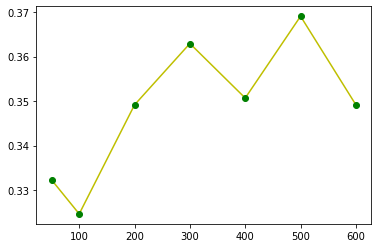

In [ ]:
plt.plot(factors, ndcg_values, 'y-')
plt.plot(factors, ndcg_values, 'go')
plt.show()

Utilizaré 500 factores latentes porque con esa cantidad se obtuvieron los mejores resultados.

In [ ]:
iterations = [1, 10, 25, 40, 50, 75, 100] 
map_values = []
ndcg_values = []

for k in iterations:  
  model_bpr_test = implicit.bpr.BayesianPersonalizedRanking(factors=k, iterations=40, use_gpu=False)
  model_bpr_test.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr_test, n=10)
  map_values.append(maprec)
  ndcg_values.append(ndcg)

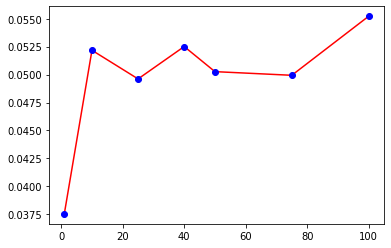

In [ ]:
plt.plot(iterations, map_values, 'r-')
plt.plot(iterations, map_values, 'bo')
plt.show()

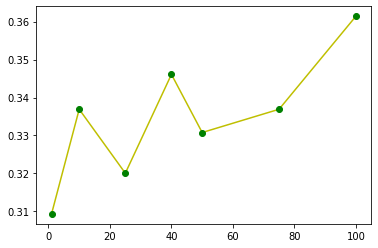

In [ ]:
plt.plot(iterations, ndcg_values, 'y-')
plt.plot(iterations, ndcg_values, 'go')
plt.show()

En ambos gráficos se ve que el mejor resultado es con 500 factores latentes y 100 iteraciones.